# Model parameter estimation for an irregularly-sampled, continuous-discrete (non-linear) dynamical system

We show how to use cd-dynamax to estimate the parameters of a continuous-discrete (non-linear) dynamical system



## Preliminaries

### Code Setup

In [1]:
# Main imports
import sys
from itertools import count

# Import jax and utils
from jax import numpy as jnp
from jax import vmap
import jax.random as jr
from jax import jit, vmap
import diffrax as dfx

# Additional, custom codebase
sys.path.append("../..")
sys.path.append("../../..")

# Our own custom src codebase
# continuous-discrete nonlinear Gaussian SSM codebase
from utils.plotting_utils import *
# CD-Nonlinear Gaussian models
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm.models import *

# Useful utility functions
from simulation_utils import *

# Plotting
import matplotlib
%matplotlib inline
# Our own custom plotting codebase
from utils.plotting_utils import *
from lorenz_plotting import *
from parameter_learning_plotting import *
# Feel free to change the default figure size
#matplotlib.rcParams['figure.figsize'] = [16, 9]


/opt/homebrew/anaconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


# Generate synthetic data

We generate data from a Lorenz 63 system, from dynamics with the following stochastic differential equations:
\begin{align*}
\frac{d x}{d t} &= a(y-x) + \sigma w_x(t) \\
\frac{d y}{d t} &= x(b-z) - y + \sigma w_y(t) \\
\frac{d z}{d t} &= xy - cz + \sigma w_z(t),
\end{align*}

With parameters $a=10, b=28, c=8/3$, the system gives rise to chaotic behavior, and we choose $\sigma=0.1$ for light diffusion.

To generate data, we numerically approximate random path solutions to this SDE using Heun's method (i.e. improved Euler), as implemented in [Diffrax](https://docs.kidger.site/diffrax/api/solvers/sde_solvers/).


We assume the observation model is
\begin{align*}
y(t) &= H x(t) + r(t) \\
r(t) &\sim N(0,R),
\end{align*}
where we choose $R=I$. 

Namely, with H=I, we have full observability, with noisy observations, sampled at irregular time intervals.

### True, data-generating model definition

In [2]:
## Main settings
state_dim = 3
emission_dim = 1

# Define a custom drift model, inherited from LearnableFunction
class lorenz63_drift(LearnableFunction):
    params: Union[Float[Array, "state_dim"], ParameterProperties]

    def f(self, x, u=None, t=None):
        foo = jnp.array(
            [
                self.params[0] * (x[1] - x[0]),
                self.params[1] * x[0] - x[1] - x[0] * x[2],
                -self.params[2] * x[2] + x[0] * x[1],
            ]
        )
        return foo

# Define the true parameters of the drift function
true_l63_drift_params = jnp.array([10.0, 28.0, 8 / 3])
# And the corresponding Lorenz 63 system
true_drift = {
    "params": lorenz63_drift(
        params=true_l63_drift_params
    ),
    "props": lorenz63_drift(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_cov = {
    "params": LearnableMatrix(
        params=jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_coefficient_param = 0.1
true_diffusion_coefficient = {
    "params": LearnableMatrix(
        params=true_diffusion_coefficient_param * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the emission function
# Full observability
H=jnp.eye(emission_dim,state_dim)
true_emission = {
    "params": LearnableLinear(
        weights=H,
        bias=jnp.zeros(emission_dim)
    ),
    "props": LearnableLinear(
        weights=ParameterProperties(),
        bias=ParameterProperties()
    ),
}

# Define the true parameters of the emission covariance
R=jnp.eye(emission_dim)
true_emission_cov = {
    "params": LearnableMatrix(
        params=R
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true initial mean and covariance
true_initial_mean = {
    "params": LearnableVector(
        params=jnp.zeros(state_dim)
    ),
    "props": LearnableVector(
        params=ParameterProperties()
    ),
}

true_initial_cov_param = 10.0
true_initial_cov = {
    "params": LearnableMatrix(
        params=true_initial_cov_param*jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Concatenate all parameters in dictionary, for later easy use
all_true_params = {
    'initial_mean': true_initial_mean,
    'initial_cov': true_initial_cov,
    'dynamics_drift': true_drift,
    'dynamics_diffusion_coefficient': true_diffusion_coefficient,
    'dynamics_diffusion_cov': true_diffusion_cov,
    'dynamics_approx_order': 2., # Check on this later
    'emission_function': true_emission,
    'emission_cov': true_emission_cov,
}

### Simulation set-up

In [3]:
# Set up seed for simulation
keys = map(jr.PRNGKey, count())

# Simulation parameters
T_total = 50
T_filter = int(0.8*T_total)
num_timesteps_total = int(T_total*100)

# Generate time points for measurements, filtering and forecasting
# We will generate different train and test sets

## Train set
t_emissions_train, t_filter_train, t_forecast_train, \
    num_timesteps_train, num_timesteps_filter_train, num_timesteps_forecast_train= \
    generate_irregular_t_emissions(
        T_total=T_total,
        num_timesteps=num_timesteps_total,
        T_filter=T_filter,
        key=next(keys)
    )

## Test set
t_emissions_test, t_filter_test, t_forecast_test, \
    num_timesteps_test, num_timesteps_filter_test, num_timesteps_forecast_test= \
    generate_irregular_t_emissions(
        T_total=T_total,
        num_timesteps=num_timesteps_total,
        T_filter=T_filter,
        key=next(keys)
    )

### Model creation: object instantiation

In [4]:
# Create CD-NLGSSM model with high fidelity diffeqsolver settings. These settings will only be used when calling .sample() for data generation

hifi_forward_settings = {
    "solver": dfx.Heun(),
    "dt0": 1e-5,
    "stepsize_controller": dfx.ConstantStepSize(),
    # dfx.PIDController(atol=1e-9, rtol=1e-7, pcoeff=0.1, icoeff=0.3, dcoeff=0),
    "tol_vbt": 1e-5,
    "max_steps": 1e6,
}  # empty uses default settings


true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim) #, diffeqsolve_settings=hifi_forward_settings)
true_params, _ = true_model.initialize(
    next(keys),
    **all_true_params
)

### Simulate data: sample from model

In [5]:
# sample true states and emissions from defined true model.
# Using transition_type="path" to solve the dynamics SDE.

## Train set
true_states_train, true_emissions_train = true_model.sample(
    true_params,
    next(keys),
    num_timesteps_train,
    t_emissions_train,
    transition_type="path" # uses the Euler-Maruyama method
)

## Test set
true_states_test, true_emissions_test = true_model.sample(
    true_params,
    next(keys),
    num_timesteps_test,
    t_emissions_test,
    transition_type="path" # uses the Euler-Maruyama method
)

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.
Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.


### Plot generated data

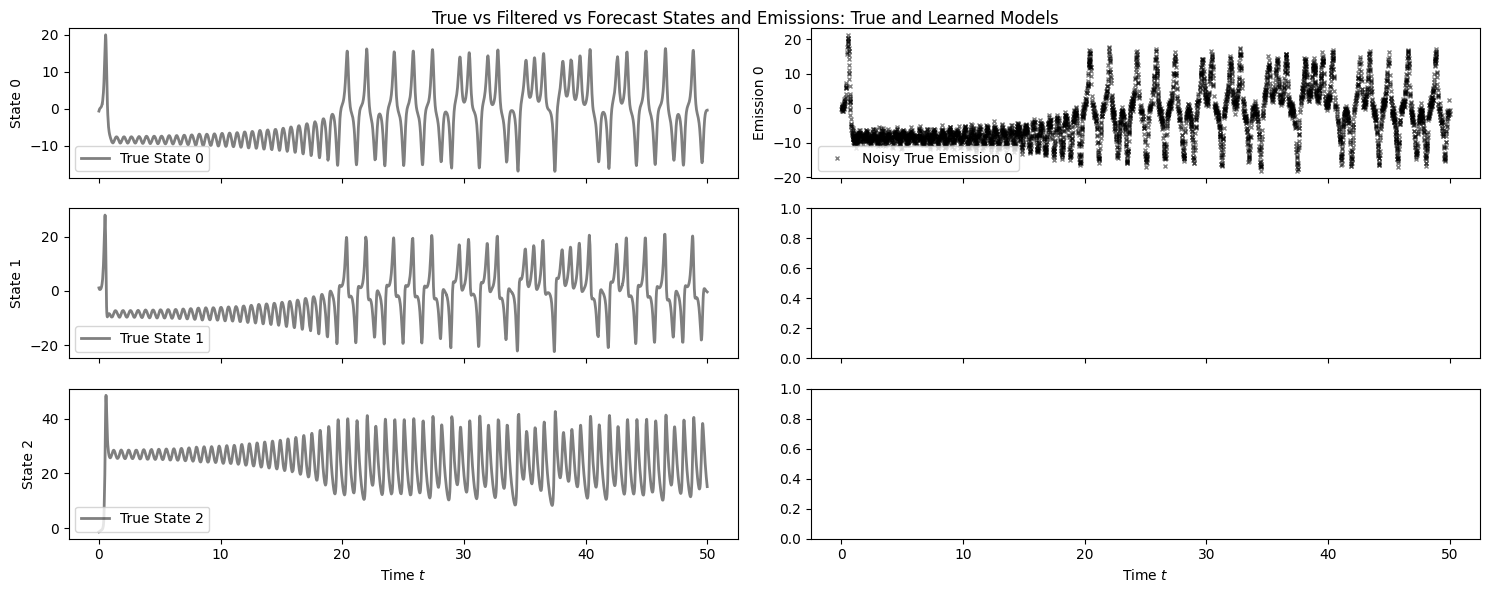

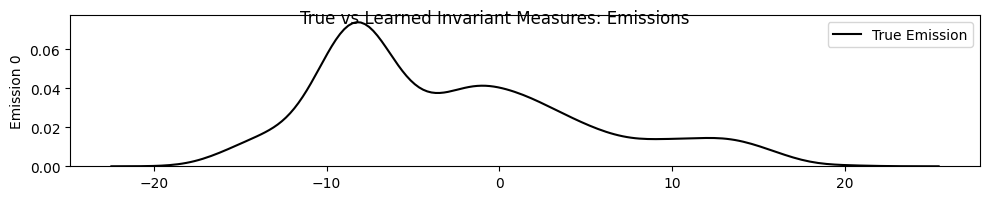

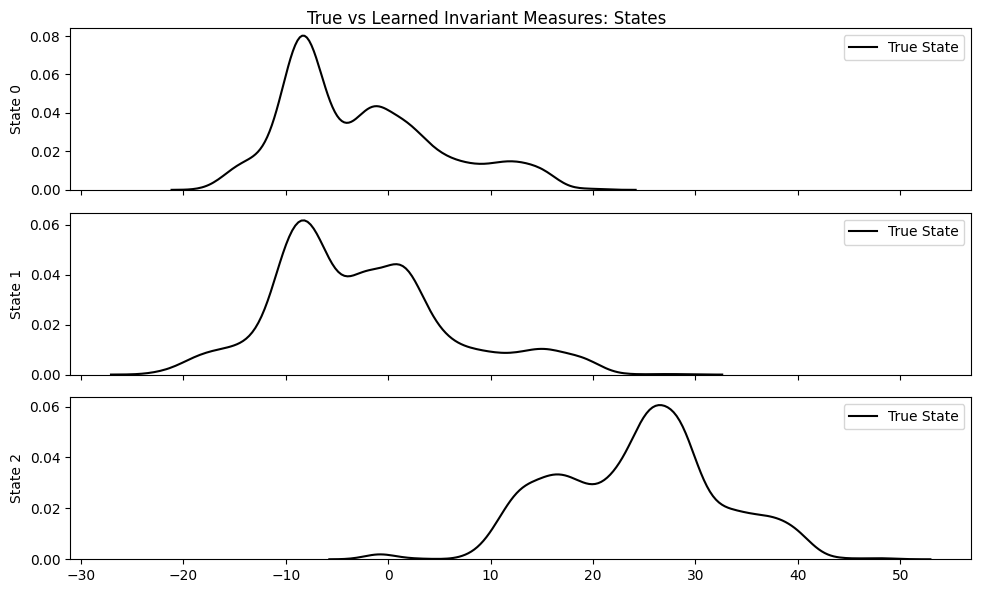

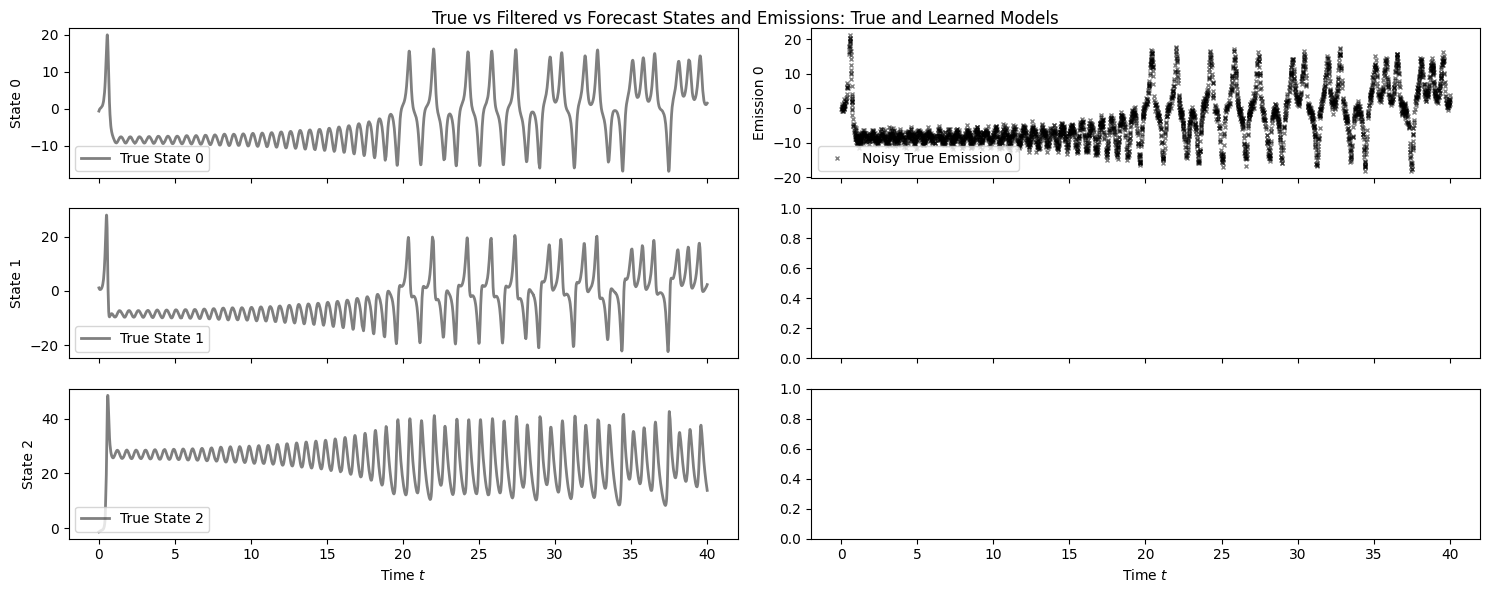

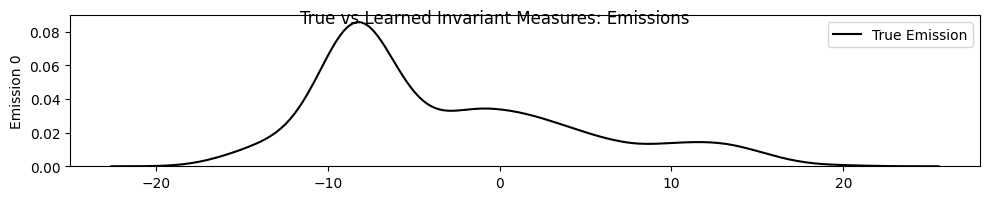

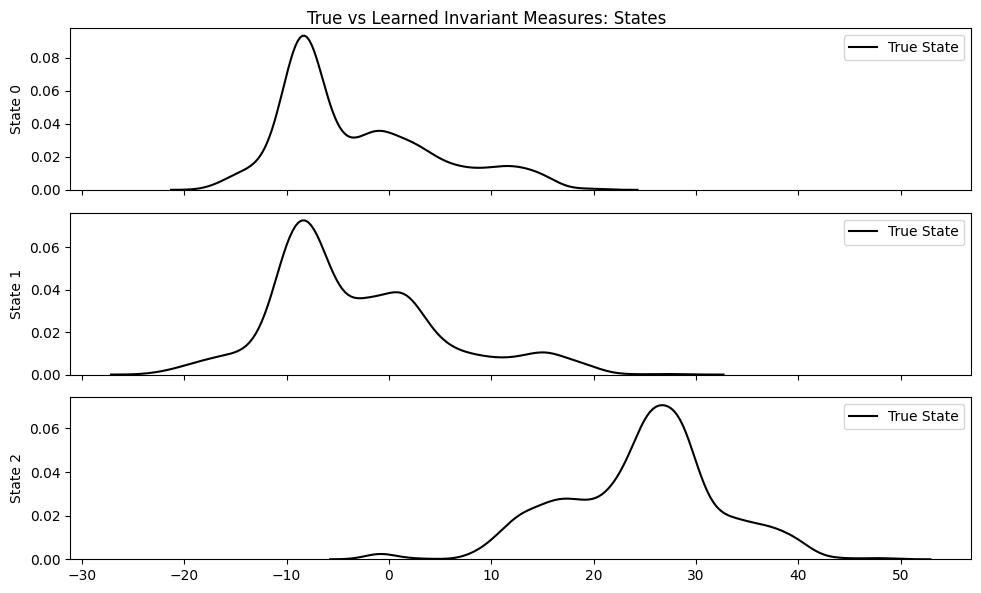

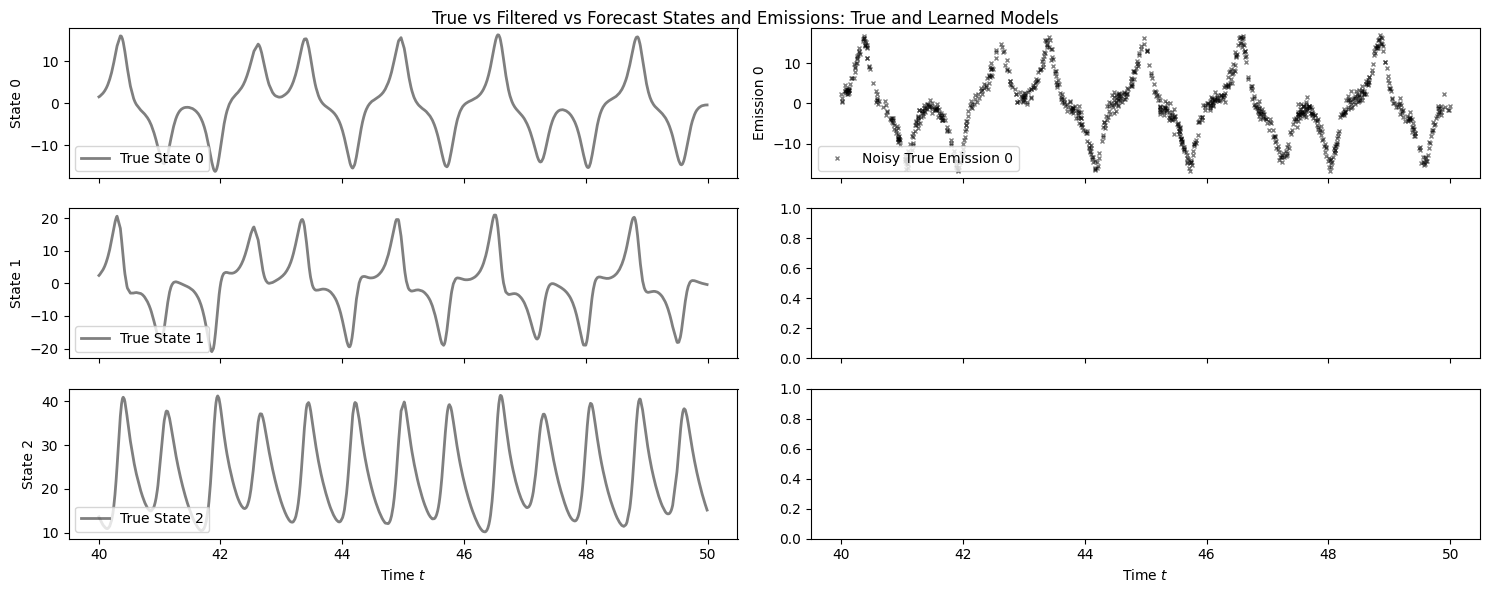

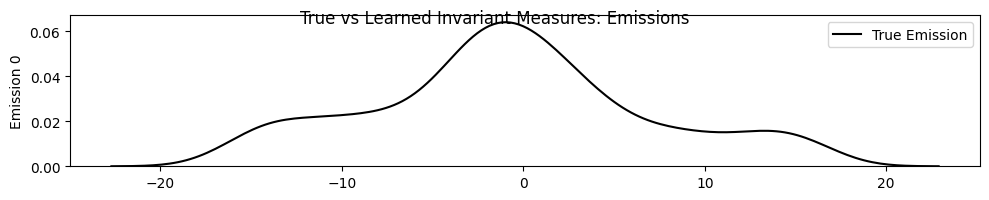

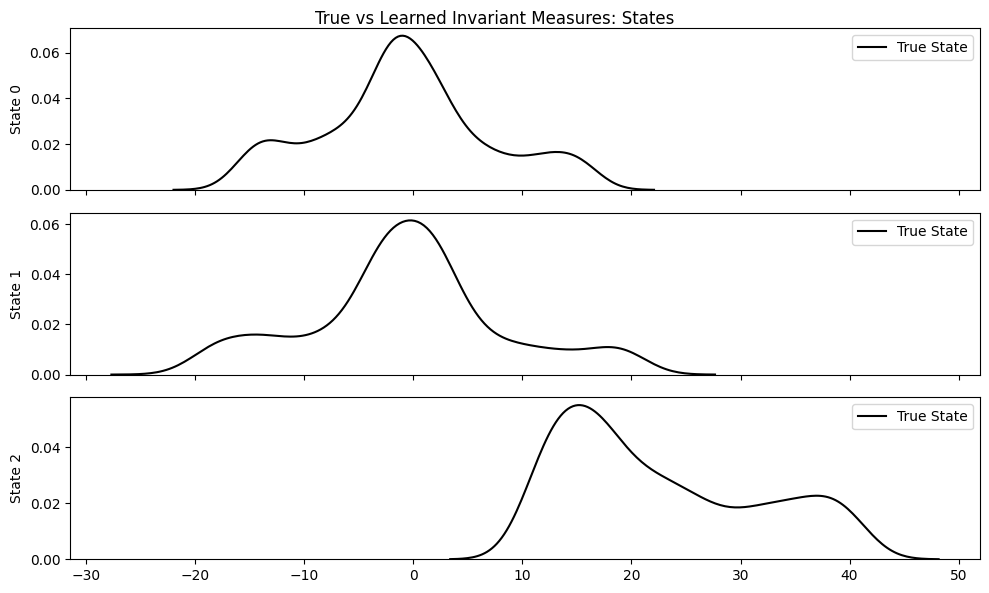

In [6]:
# Plot all the training data
plot_advanced2(
    time_grid_all=t_emissions_train,
    true_states=true_states_train,
    true_emissions_noisy=true_emissions_train,
    emission_function=true_params.emissions.emission_function
)

# Plot the filtering training data
plot_advanced2(
    time_grid_all=t_emissions_train,
    true_states=true_states_train,
    true_emissions_noisy=true_emissions_train,
    emission_function=true_params.emissions.emission_function,
    t_start=0,
    t_end=T_filter
)

# Plot the forecasting training data
plot_advanced2(
    time_grid_all=t_emissions_train,
    true_states=true_states_train,
    true_emissions_noisy=true_emissions_train,
    emission_function=true_params.emissions.emission_function,
    t_start=T_filter,
    t_end=T_total
)

# Parameter learning

### We start by defining a new model that is learnable

- We want to learn a model that might or might not be within the same function class of the data-generating mechanism

- The learnable model will be a ContDiscreteNonlinearGaussianSSM

- Here, we define the same model family as the data-generating model, EXCEPT without the specified drift function
    - i.e., all parameters are known, except the drift function
    - we parameterize the unknown drift with a neural network and learn it from data

### Learning hint

- The drift function needs to be constrained so that it does not encourage solutions to leave a bounded domain. We use `adjust_rhs` to do this.
  - `adjust_rhs` freezes the drift vector field at 0 when the state leaves a pre-defined constraint box [-100, 100] component-wise. 
  - It can also be modified to point the drift vector field inward under these conditions (e.g., via `-x`)
  - Another sometimes useful trick is to also constrain the absolute values of the drift vector field itself to be within [-1000, 1000] by applying a clamp. This enforces a regularity condition on the drift function, which can help with learning and prevent large oscillations.

- Even after constraining the drift function, we can still sometimes see NN-based drifts that induce NaN marginal loglikelihood. This occurs when the filter attempts to perform the `condition_on` step (i.e., estimating $p(x_k | Y_k)$) using a predicted covariance that is highly non-PSD.
Non-PSD predicted covariance matrices come from numerical solutions to ODE-based representations of prediction covariances. The first and second order EKF, for example, integrate the prior covariance through jacobians of the state dynamics; the solution to these ODEs (i.e. Sarkka thesis Equation 3.158) is PSD, but numerical solutions may deviate from this!
  - One way to cope with this is to use very high-fidelity solvers for the ODEs; try something like `Dopri8` and a `PIDController` for adaptive step sizes. However, this incurs substantial computational cost, especially when backpropagating through the ODE solver to obtain gradients needed for inference.
  - A more efficient approach is to use a simpler filtering algorithm that does not evolve the covariance through the state dynamics. We implemented a `zeroth` order EKF, which simply evolves mean dynamics, then adds covariance at the end of a forecast (avoids numerically integrating covariances through time). This is what we use in the following example.


### CODE hint

- By default, all ParamProperties are set to trainable=True

- So, make sure you EXPLICITLY set trainable=False for all parameters you DO NOT want to learn/infer

### Neural Network classes

In [7]:
from typing import NamedTuple, Tuple, Optional, Union
from flax import linen as nn
from jax import jit

@jit
def adjust_rhs(x, rhs, lower_bound=-100, upper_bound=100, epsilon=1e-10):
    """
    Adjust the right-hand side of the ODE to ensure that the state
    remains within the bounds [-100, 100]
    """

    # Use a small epsilon to ensure numerical stability
    # Smoothly adjust the bounds to avoid gradient discontinuities
    safe_lower_bound = jnp.where(x <= lower_bound, lower_bound + epsilon, x)
    safe_upper_bound = jnp.where(x >= upper_bound, upper_bound - epsilon, x)

    # Conditionally adjust rhs using the safe bounds
    rhs = jnp.where(safe_lower_bound <= lower_bound, jnp.maximum(rhs, 0), rhs)
    rhs = jnp.where(safe_upper_bound >= upper_bound, jnp.minimum(rhs, 0), rhs)

    return rhs


class LearnableNN_TwoLayerGeLU(NamedTuple):
    """Two-layer neural network with Gaussian Error Linear Units
    weights1: weights of the first layer
    bias1: bias of the first layer
    weights2: weights of the second layer
    bias2: bias of the second layer

    f(x) = weights2 @ gelu(weights1 @ x + bias1) + bias2
    """

    weights1: Union[Float[Array, "hidden_dim input_dim"], ParameterProperties]
    bias1: Union[Float[Array, "hidden_dim"], ParameterProperties]
    weights2: Union[Float[Array, "output_dim hidden_dim"], ParameterProperties]
    bias2: Union[Float[Array, "output_dim"], ParameterProperties]
    scale: Union[Float, ParameterProperties]

    def f(self, x, u=None, t=None):
        """This rhs operates in original space."""

        # compute derivative given by NN
        rhs = self.weights2 @ nn.gelu(self.weights1 @ x + self.bias1) + self.bias2

        return adjust_rhs(x, rhs)

In [8]:
## Main settings
state_dim = 3
emission_dim = 1

# Define the learnable drift model as a two-layer neural network with 100 hidden units and GeLU activation
hidden_dim = 100
learnable_drift = {
    "params": LearnableNN_TwoLayerGeLU(
        weights1=jnp.sqrt(2.0 / state_dim) * jr.normal(next(keys), (hidden_dim, state_dim)),
        bias1=jnp.zeros((hidden_dim,)),
        weights2=jnp.sqrt(2.0 / hidden_dim) * jr.normal(next(keys), (state_dim, hidden_dim)),
        bias2=jnp.zeros((state_dim,)),
        scale=jnp.zeros(()),
    ),
    "props": LearnableNN_TwoLayerGeLU(
        weights1=ParameterProperties(trainable=True),
        bias1=ParameterProperties(trainable=True),
        weights2=ParameterProperties(trainable=True),
        bias2=ParameterProperties(trainable=True),
        scale=ParameterProperties(trainable=True),
    ),
}
## All parameters below are NOT learnable
learnable_diffusion_cov = {
    "params": LearnableMatrix(
        params=jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            trainable=False,
            constrainer=RealToPSDBijector()
        )
    ),
}

# The diffusion coefficient is fixed to non-learnable identity
learnable_diffusion_coefficient = {
    "params": LearnableMatrix(
        params=true_diffusion_coefficient_param * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(trainable=False)
    ),
}

# The emission function is fixed to non-learnable identity
learnable_emission = {
    "params": LearnableLinear(
        weights=H,
        bias=jnp.zeros(emission_dim)
    ),
    "props": LearnableLinear(
        weights=ParameterProperties(trainable=False),
        bias=ParameterProperties(trainable=False)
    ),
}

# The emission covariance is fixed to non-learnable identity
learnable_emission_cov = {
    "params": LearnableMatrix(
        params=R
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            trainable=False,
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the initial mean and covariance
learnable_initial_mean = {
    "params": LearnableVector(
        params=jnp.zeros(state_dim)
    ),
    "props": LearnableVector(
        params=ParameterProperties(trainable=False)
    ),
}

learnable_initial_cov = {
    "params": LearnableMatrix(
        params=10.0 * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(params=ParameterProperties(trainable=False, constrainer=RealToPSDBijector())),
}

# Concatenate all parameters in dictionary, for later easy use
all_learnable_params = {
    "initial_mean": learnable_initial_mean,
    "initial_cov": learnable_initial_cov,
    "dynamics_drift": learnable_drift,
    "dynamics_diffusion_coefficient": learnable_diffusion_coefficient,
    "dynamics_diffusion_cov": learnable_diffusion_cov,
    "dynamics_approx_order": 2.,  # Check on this later
    "emission_function": learnable_emission,
    "emission_cov": learnable_emission_cov,
}

### Define, instantiate and initialize the learnable model

In [9]:
# Create CD-NLGSSM model
learnable_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
initial_learnable_params, learnable_props = learnable_model.initialize(
    next(keys),
    **all_learnable_params
)

# Frequentist parameter estimation: Maximum likelihood estimates MLE


## Maximum likelihood parameter estimation for an irregularly-sampled, continuous-discrete (non-linear) Gaussian dynamical system

- MLE based on SGD over marginalized log-probability
- We will use Extended Kalman Filtering to compute the marginal log probability
    - Note that other options (EnKF and UKF) are implemented and can be readily used
- We use a zeroth order EKF to avoid numerical issues with non-PSD covariance matrices

### Define the filter to use to compute the marginalized log-likelihood

In [10]:
# Filter: EKF
from continuous_discrete_nonlinear_gaussian_ssm import EKFHyperParams
filter_hyperparams = EKFHyperParams(diffeqsolve_settings={"max_steps": 1e2,
                                                          "solver": dfx.Heun(), 
                                                          # at default dt0=0.01, we get 2.5x speedup with Heun vs Dopri5, with sufficient accuracy for this problem
                                                          },
                                    state_order="zeroth")

### Define the SGD optimizer to use

### Some standard optimization tricks for training neural networks are used below:
- We use a learning rate scheduler
- We use gradient clipping

In [11]:
import optax
num_epochs = 3000

# define a learning rate scheduler
initial_learning_rate = 1e-1
decay_factor = 0.5  # Decay the learning rate by a factor
epochs_per_step = 400  # Number of epochs per decay step

# Define the boundaries where the decay should happen
# In this case, every 20 epochs
boundaries = [epochs_per_step * i for i in range(1, num_epochs // epochs_per_step + 1)]

# Define the values of the learning rates at each boundary
values = [initial_learning_rate * (decay_factor**i) for i in range(len(boundaries) + 1)]

# Create a step decay learning rate schedule
scheduler = optax.piecewise_constant_schedule(
    init_value=initial_learning_rate, boundaries_and_scales={boundary: decay_factor for boundary in boundaries}
)

# define an optimizer with a learning rate of 1e-1 and gradient clipping
my_optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    optax.scale(-1.0),
)

### Fit the learnable model, using SGD to observed data, using the EKF filter to marginalize the latent states

In [12]:
# Fit test_model by running SGD, with EKF filter
fitted_params, neg_marginal_lls, param_history, grad_history = learnable_model.fit_sgd(
    initial_learnable_params,
    learnable_props,
    true_emissions_train,
    t_emissions=t_emissions_train,
    filter_hyperparams=filter_hyperparams,
    optimizer=my_optimizer,
    num_epochs=num_epochs,
    return_grad_history=True,
    return_param_history=True,
)

# Note that fit_sgd returns normalized negative log-likelihoods
# So we multiply it by the number of datapoints in emissions
marginal_lls = -neg_marginal_lls * true_emissions_train.size

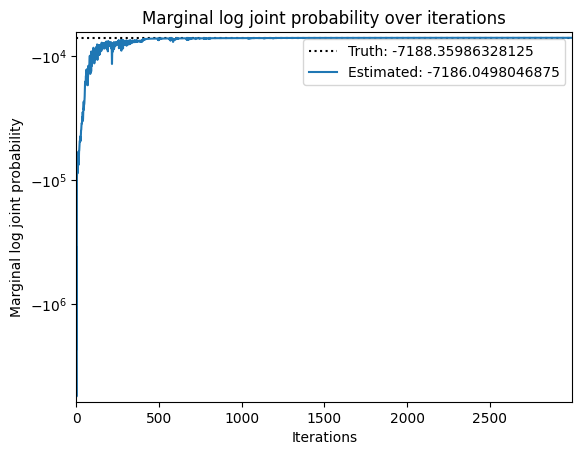

In [13]:
plot_mll_learning_curve(
    true_model,
    true_params,
    true_emissions_train,
    t_emissions_train,
    marginal_lls,
)

In [14]:
# HMC is initialized at random parameters
n_mcmc_samples = 100

nuts_algorithm = {
    "type": "nuts",
    "parameters": {
        "num_steps": 200,
    },
}

# Run
warmup_samples, mcmc_samples, warmup_logprobs, mcmc_log_probs = learnable_model.fit_mcmc(
    fitted_params,
    learnable_props,
    true_emissions_train,
    t_emissions=t_emissions_train,
    filter_hyperparams=filter_hyperparams,
    n_mcmc_samples=n_mcmc_samples,
    mcmc_algorithm=nuts_algorithm,
    verbose=True,
)

Running window adaptation



Running MCMC inference loop...


### Visualize learning: marginal log-likelihood evolution

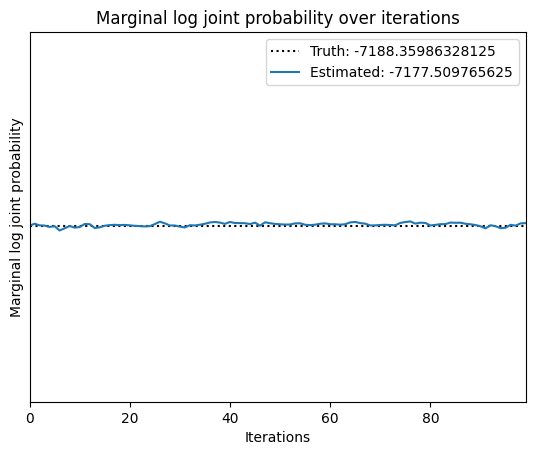

In [15]:
plot_mll_learning_curve(
    true_model,
    true_params,
    true_emissions_train,
    t_emissions_train,
    mcmc_log_probs,
)

In [16]:
# Define filter and forecast time points
T0 = 5 # Ignore initial transient
T_filter_end = 25 # End of filtering
T_forecast_end = 45 # End of forecasting

In [17]:
# vmap over filter and forecast function
(hmc_filtered_train, hmc_forecasted_train, \
    hmc_start_idx_filter, hmc_stop_idx_filter, \
    hmc_start_idx_forecast, hmc_stop_idx_forecast
    ) = vmap(
        filter_and_forecast,
        in_axes=(0, None, None, None, None, None, None) # only over param_samples
    )(
        mcmc_samples,
        filter_hyperparams,
        t_emissions_train,
        true_emissions_train,
        T0,
        T_filter_end,
        T_forecast_end
    )


In [18]:
# vmap over cdnlssm emissions function, to get the filtered emissions
# based on the vmapped params, filtered state means and filtered state covariances
(hmc_filtered_train_emissions_mean, hmc_filtered_train_emissions_covariance) = vmap(
        cdnlgssm_emissions,
        in_axes=(0, None, 0, 0, None, None, None) # vmap over axis 0 of params, state_means and state_covs
    )(
        mcmc_samples,
        t_emissions_train[hmc_start_idx_filter[0]:hmc_stop_idx_filter[0]],
        hmc_filtered_train.filtered_means,
        hmc_filtered_train.filtered_covariances,
        None,
        EKFHyperParams(),
        next(keys),
    )

In [19]:
# vmap over cdnlssm emissions function, to get the forecasted emissions
# based on the vmapped params, forecasted state means and state covariances
(hmc_forecasted_train_emissions_mean, hmc_forecasted_train_emissions_covariance) = vmap(
        cdnlgssm_emissions,
        in_axes=(0, None, 0, 0, None, None, None) # vmap over axis 0 of params, state_means and state_covs
    )(
        mcmc_samples,
        t_emissions_train[hmc_start_idx_forecast[0]:hmc_stop_idx_forecast[0]],
        hmc_forecasted_train.forecasted_state_means,
        hmc_forecasted_train.forecasted_state_covariances,
        None,
        EKFHyperParams(),
        next(keys),
    )

In [20]:
start_idx_filter_hmc = hmc_start_idx_filter[0]
stop_idx_filter_hmc = hmc_stop_idx_filter[0]
start_idx_forecast_hmc = hmc_start_idx_forecast[0]
stop_idx_forecast_hmc = hmc_stop_idx_forecast[0]

# Auxiliary function to split parameter samples into a list
def split_params(params, index):
    """Extracts the specific index from each parameter in the structure."""
    return jax.tree_map(lambda x: x[index], params)

# Split the emission functions into a list
emission_function_list = [split_params(mcmc_samples.emissions.emission_function, i) for i in range(n_mcmc_samples)]
# now extract the .f function from each of the emission functions
emission_function_f_list = [x.f for x in emission_function_list]

### Plot performance of filtering and forecasting on training data

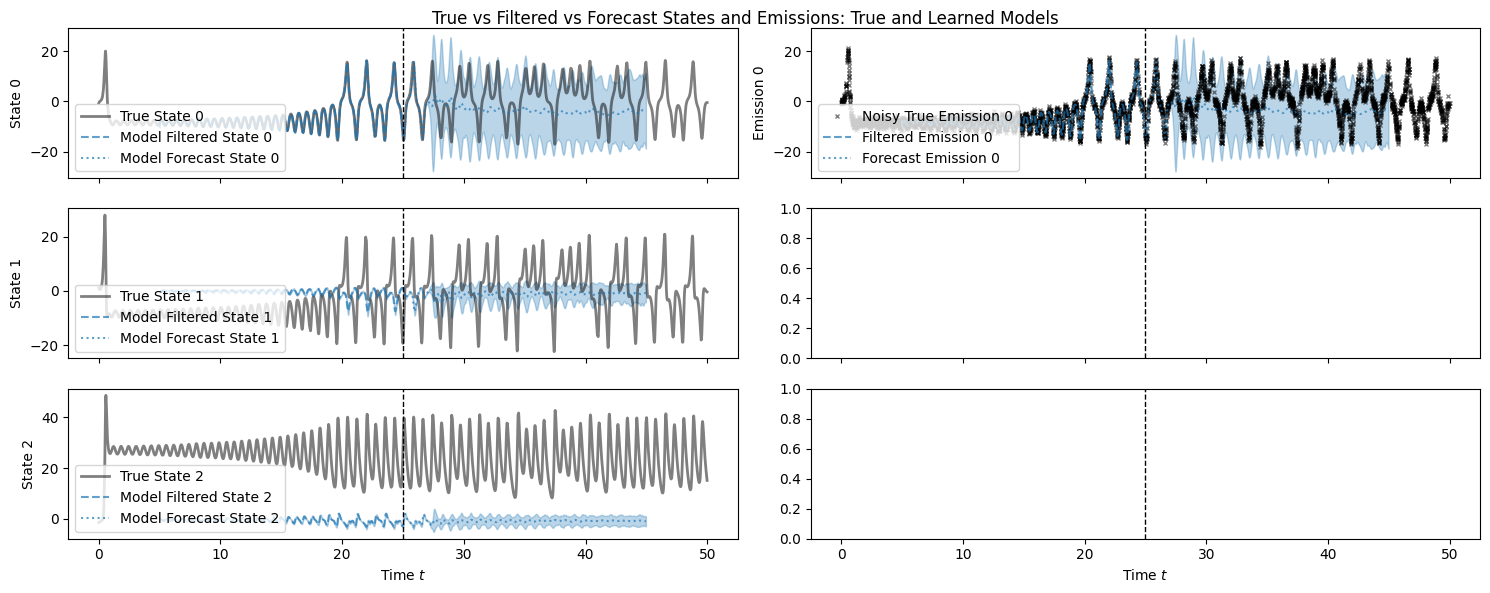

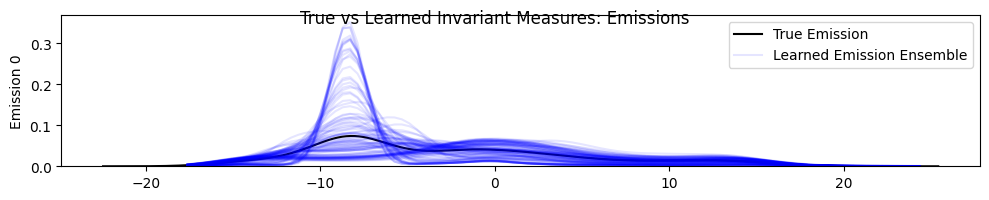

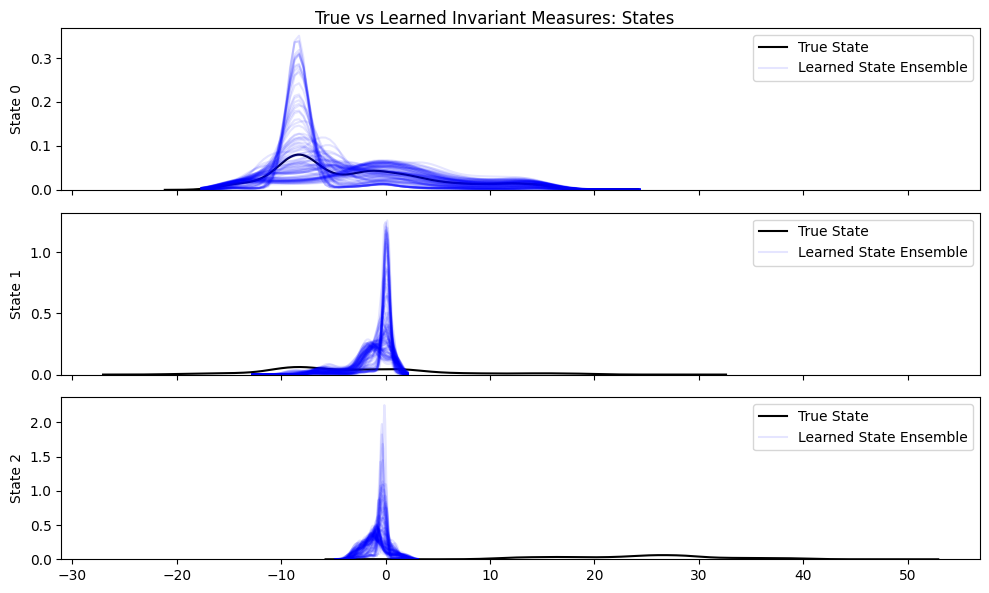

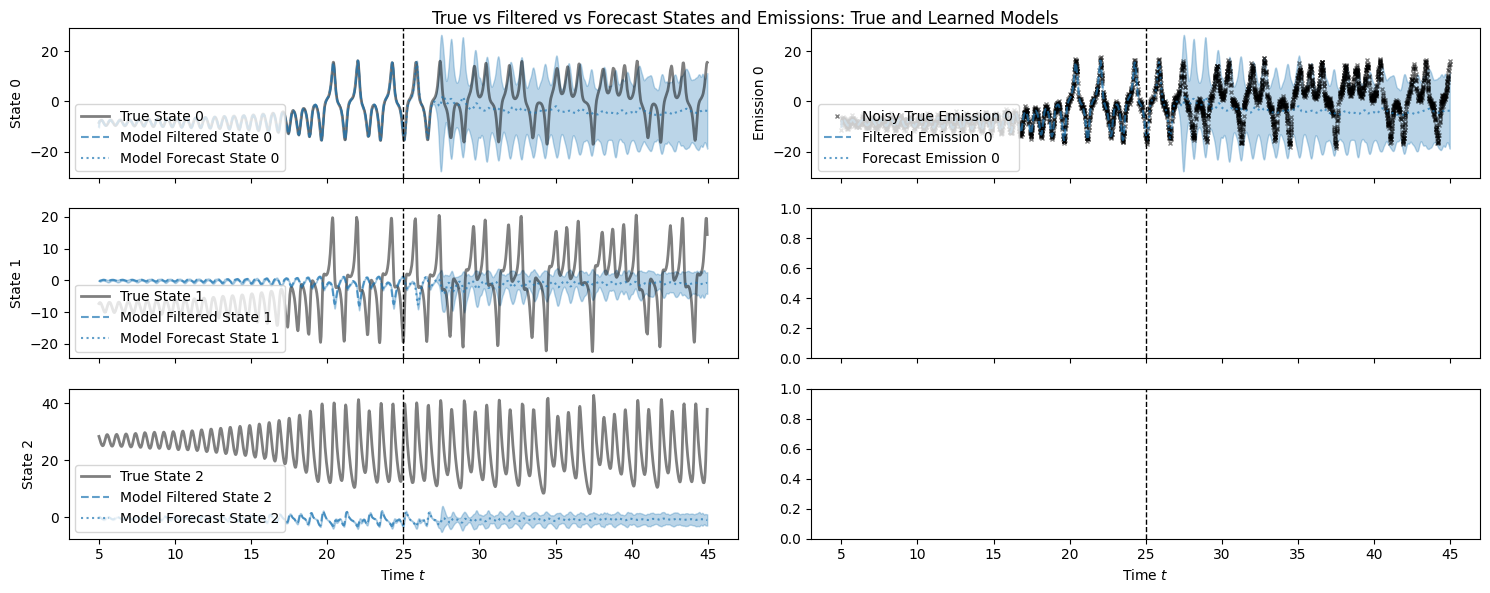

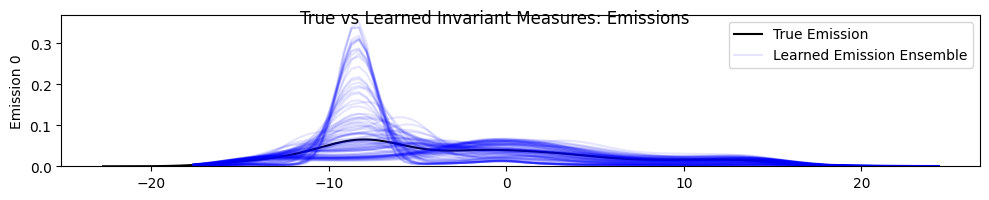

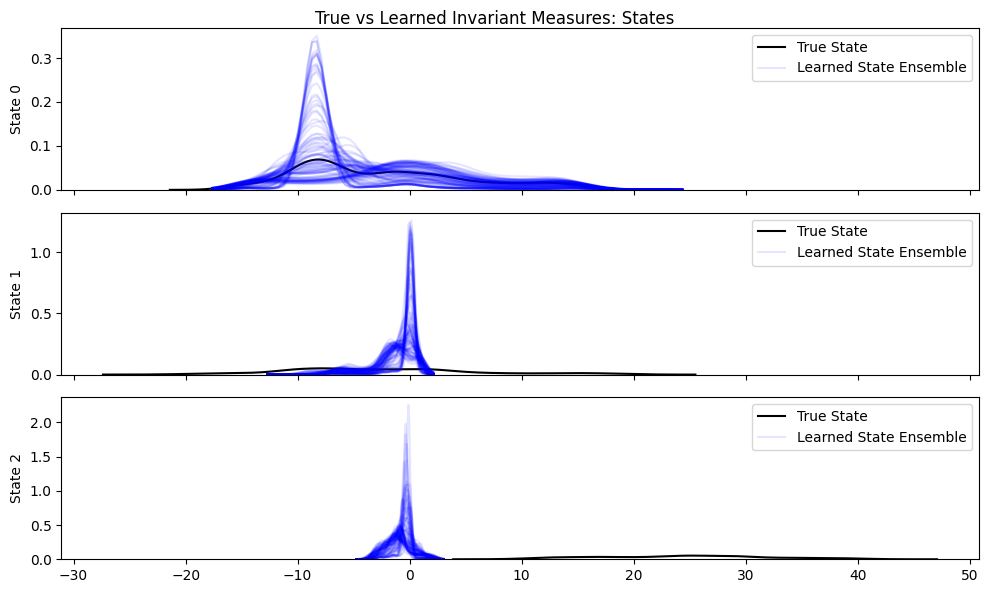

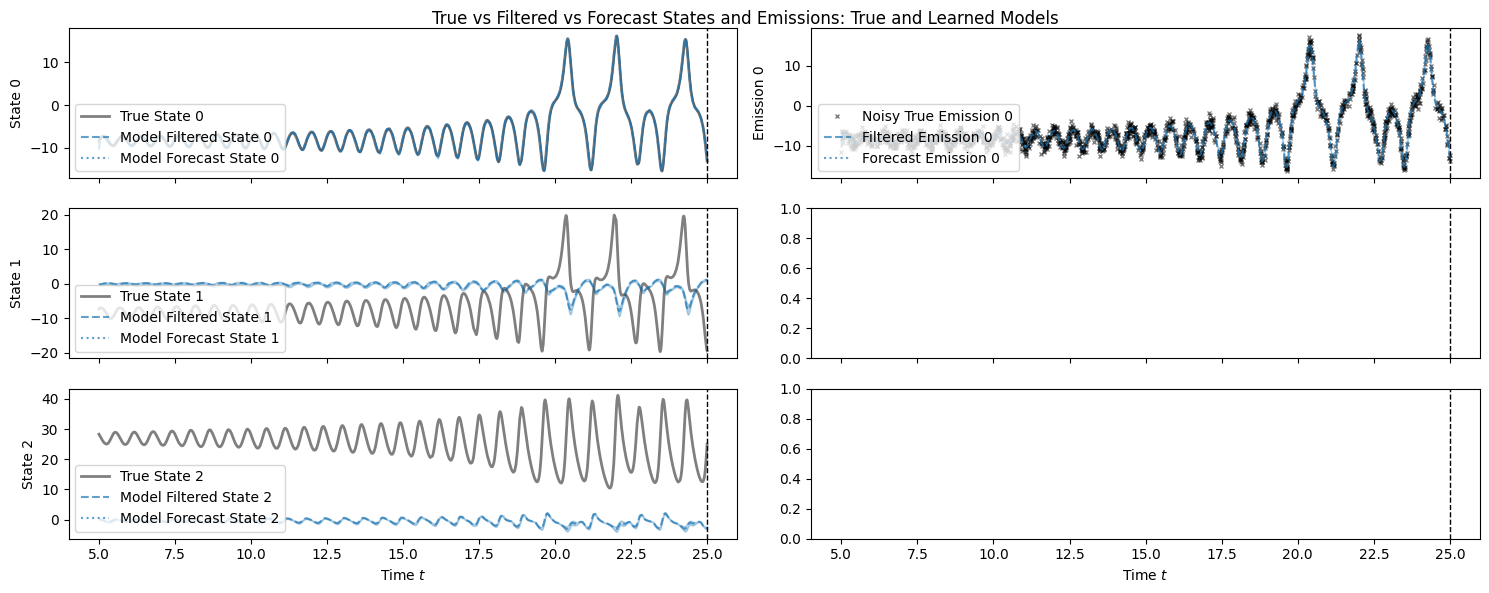

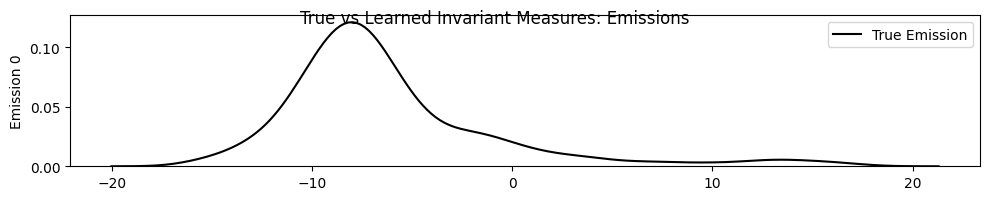

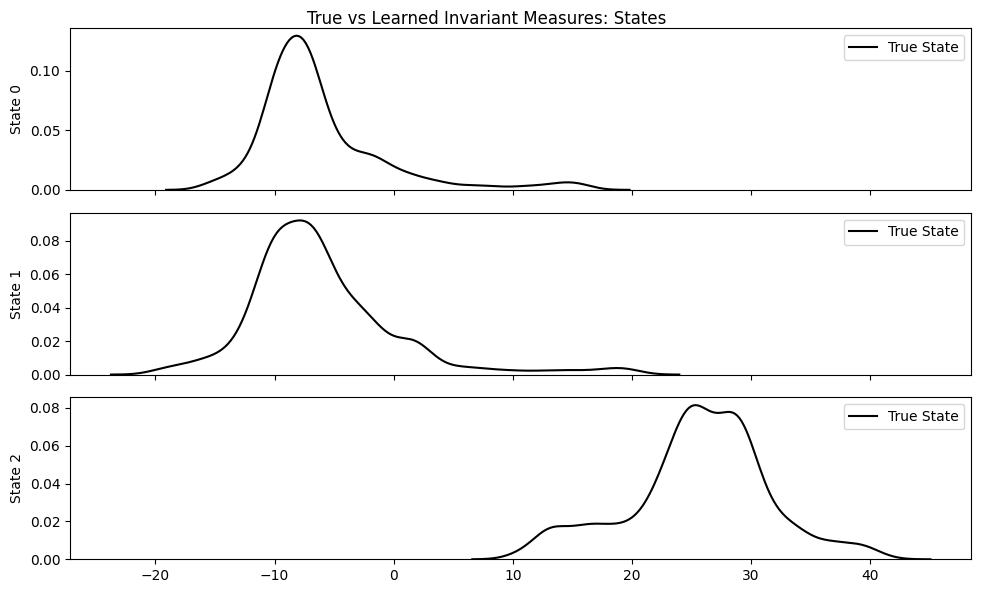

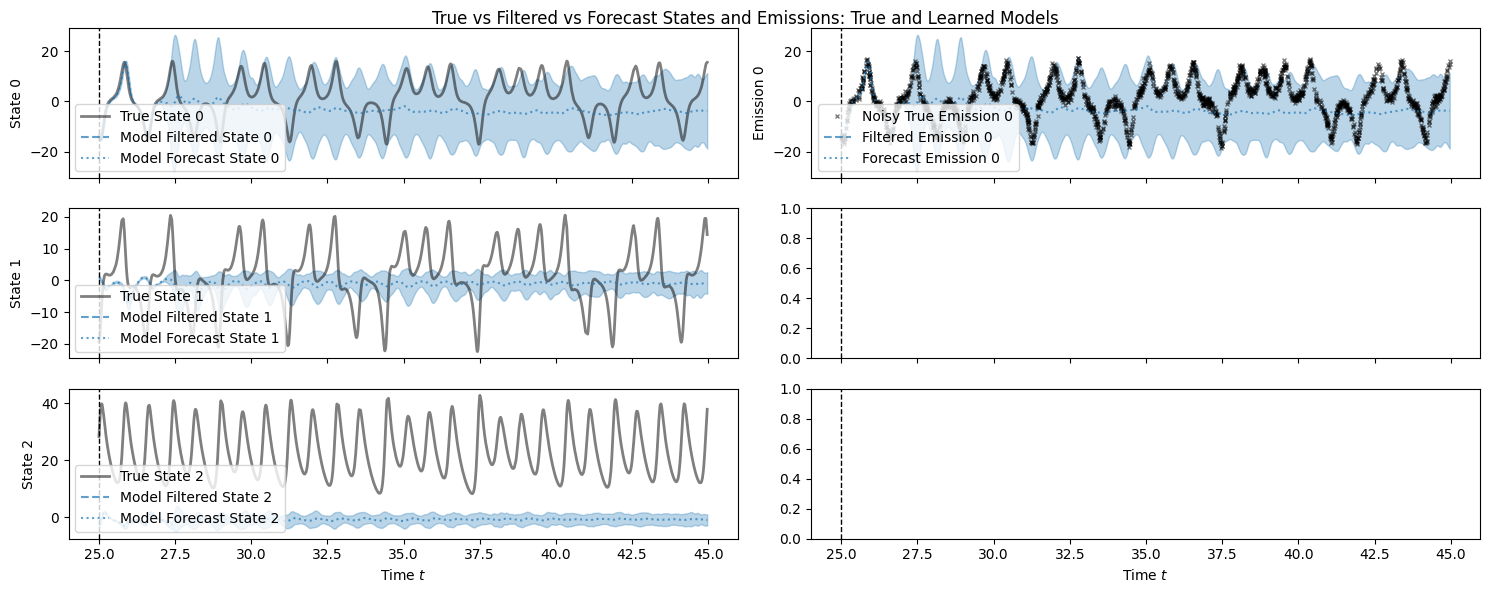

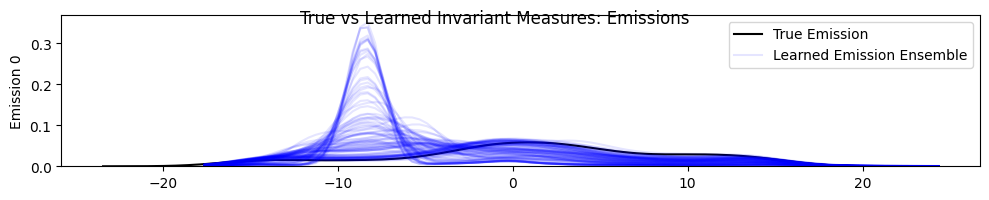

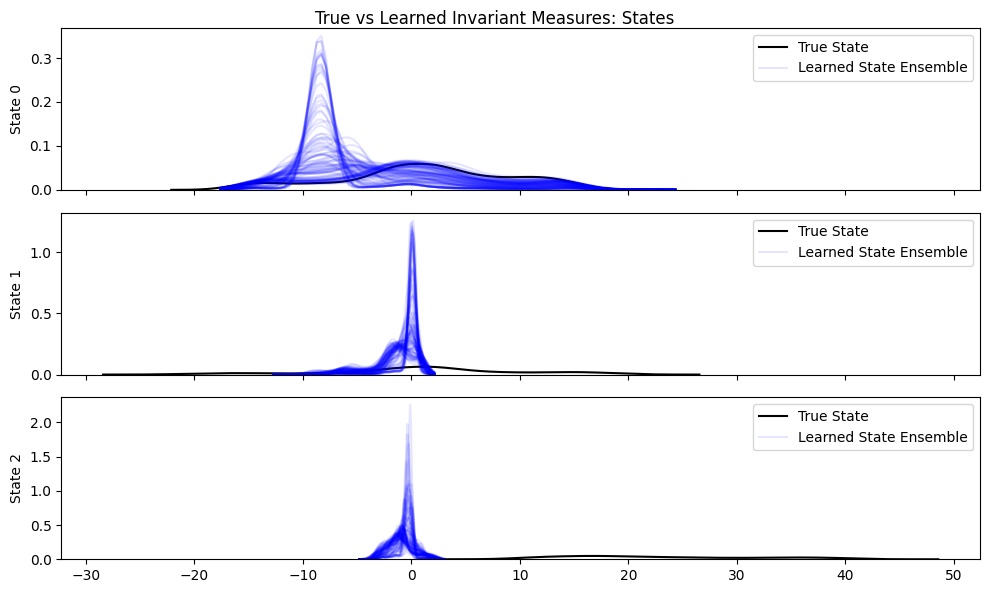

In [32]:
# Plot the true states and emissions, and the EKF estimates
for t_start, t_end in [
        (None, None), # Plot all
        (T0, T_forecast_end), # Plot from T0 until T_forecast_end, i.e., filtering and forecasting
        (T0, T_filter_end), # Plot from T0 until T_forecast_end, i.e., filtering
        (T_filter_end, T_forecast_end) # Plot from T_filter_end until T_forecast_end, i.e., forecasting
    ]:
    plot_advanced2(
        time_grid_all=t_emissions_train,
        true_states=true_states_train,
        true_emissions_noisy=true_emissions_train,
        emission_function=emission_function_f_list,
        time_grid_filter=t_emissions_train[start_idx_filter_hmc:stop_idx_filter_hmc],
        model_filtered_states=hmc_filtered_train.filtered_means,
        time_grid_forecast=t_emissions_train[start_idx_forecast_hmc:stop_idx_forecast_hmc],
        model_forecast_states=hmc_forecasted_train.forecasted_state_means,
        t_start=t_start,
        t_end=t_end,
        N_samples=n_mcmc_samples,
    )

### Plot the sequence of learned drift parameters